# Importar as bibliotecas

In [1]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import hydroeval as he
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
from scipy.stats import kstest
from scipy.stats import ks_2samp
import pickle
import fasttreeshap
import plotly.express as px 
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/Users/fernandosaraiva/anaconda3/envs/tamanduatei/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parâmetros para reprodutibilidade
np.random.seed(42)

# Obtenção dos Dados

In [3]:
df_2018 = pd.read_csv ('data/series_temporais_tratadas_2018.csv').drop(['Unnamed: 0'],axis=1)
df_2019 = pd.read_csv ('data/series_temporais_tratadas_2019.csv').drop(['Unnamed: 0'],axis=1)
df_2020 = pd.read_csv ('data/series_temporais_tratadas_2020.csv').drop(['Unnamed: 0'],axis=1)
df_2021 = pd.read_csv ('data/series_temporais_tratadas_2021.csv').drop(['Unnamed: 0'],axis=1)
df_2022 = pd.read_csv ('data/series_temporais_tratadas_2022.csv').drop(['Unnamed: 0'],axis=1)
df_2023 = pd.read_csv ('data/series_temporais_tratadas_2023.csv').drop(['Unnamed: 0'],axis=1)
for df in [df_2018,df_2019,df_2020,df_2021,df_2022,df_2023]:
    df['intervalo'] = pd.to_datetime(df['intervalo'])

In [4]:
df_total = pd.DataFrame()
# obs.: em 2021, excluímos um período em que a estação alvo 413 estava com problemas
for df in [df_2018,df_2019,df_2020,df_2021.drop(df_2021.index[3000:4000]),df_2022]:
    df_total = pd.concat([df_total,df], axis = 0)


# Remover estações ruins (descobrimos que a 1000580 não tem nada a ver e a 143 está com problemas em 2021 e 2022)
df_total = df_total.drop(columns = ['valor_leitura_flu_143', 'valor_leitura_flu_1000580'])

In [5]:
df_total.to_csv('data_tamanduatei_2018_to_2022')

In [6]:
df_total['year'] = df_total['intervalo'].dt.year

In [7]:
pluviometric_stations = ['valor_leitura_plu_143','valor_leitura_plu_283','valor_leitura_plu_413','valor_leitura_plu_511','valor_leitura_plu_514','valor_leitura_plu_563','valor_leitura_plu_629','valor_leitura_plu_1000500','valor_leitura_plu_1000510','valor_leitura_plu_1000868']

In [8]:
df_total[['intervalo','year','valor_leitura_flu_413'] + pluviometric_stations]

,intervalo,year,valor_leitura_flu_413,valor_leitura_plu_143,valor_leitura_plu_283,valor_leitura_plu_413,valor_leitura_plu_511,valor_leitura_plu_514,valor_leitura_plu_563,valor_leitura_plu_629,valor_leitura_plu_1000500,valor_leitura_plu_1000510,valor_leitura_plu_1000868
0,2018-01-01 02:00:00+00:00,2018,71707.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 02:10:00+00:00,2018,71705.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 02:20:00+00:00,2018,71703.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 02:30:00+00:00,2018,71702.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 02:40:00+00:00,2018,71700.300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,2022-04-01 02:10:00+00:00,2022,71675.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
12956,2022-04-01 02:20:00+00:00,2022,71674.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12957,2022-04-01 02:30:00+00:00,2022,71675.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12958,2022-04-01 02:40:00+00:00,2022,71676.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_part1 = df_total[df_total['year']==2018]
train_part2 = df_total[df_total['year']==2019]
#train = df_total[df_total['year']==2018]
test = df_total[df_total['year']==2020]

In [10]:
train_part1['valor_leitura_flu_413_future'] = train_part1['valor_leitura_flu_413'].shift(periods=-11)
train_part1.dropna(inplace=True)
train_part2['valor_leitura_flu_413_future'] = train_part2['valor_leitura_flu_413'].shift(periods=-11)
train_part2.dropna(inplace=True)
test['valor_leitura_flu_413_future'] = test['valor_leitura_flu_413'].shift(periods=-11)
test.dropna(inplace=True)

train = pd.concat([train_part1,train_part2],axis=0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

In [11]:
X_train = train.drop(columns = ['intervalo','valor_leitura_flu_413_future'])
y_train = train['valor_leitura_flu_413_future'].values

X_test = test.drop(columns = ['intervalo','valor_leitura_flu_413_future'])
y_test = test['valor_leitura_flu_413_future'].values

In [12]:
# Tutorial
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

mm = MinMaxScaler()
ss = StandardScaler()

mm.fit(X_train)
ss.fit(X_train)
X_train_trans = ss.transform(X_train)
X_test_trans = ss.transform(X_test)

mm.fit(y_train.reshape(-1, 1))
ss.fit(y_train.reshape(-1, 1))

y_train_trans = mm.transform(y_train.reshape(-1, 1))
y_test_trans = mm.transform(y_test.reshape(-1, 1))

In [13]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_train_part1, y_train_part1 = split_sequences(X_train_trans[0:12949], y_train_trans[0:12949], 12, 1)
X_train_part2, y_train_part2 = split_sequences(X_train_trans[12949:], y_train_trans[12949:], 12, 1)
X_test, y_test = split_sequences(X_test_trans, y_test_trans, 12, 1)
print(X_train_part1.shape, y_train_part1.shape)

(12938, 12, 17) (12938, 1)


In [14]:
X_train = np.concatenate((X_train_part1, X_train_part2), axis = 0)
y_train = np.concatenate((y_train_part1, y_train_part2), axis = 0)

In [15]:
# convert to pytorch tensors
X_train_tensors = torch.from_numpy(X_train)
X_test_tensors = torch.from_numpy(X_test)

y_train_tensors = torch.from_numpy(y_train)
y_test_tensors = torch.from_numpy(y_test)

In [16]:
X_train_tensors = X_train_tensors.to(torch.float32)
y_train_tensors = y_train_tensors.to(torch.float32)
X_test_tensors = X_test_tensors.to(torch.float32)
y_test_tensors = y_test_tensors.to(torch.float32)

In [17]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 12, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 12, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([25876, 12, 17]) torch.Size([25876, 1])
Testing Shape: torch.Size([13082, 12, 17]) torch.Size([13082, 1])


In [146]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, dropout=0.4) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        #h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype = torch.float32)
        # cell state
        #c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype = torch.float32)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [147]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
    return test_preds

In [148]:
CPU= False
device = "cpu" if CPU else torch.device("mps")
print("Device is :: {}".format(device))

Device is :: mps


In [149]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 300
learning_rate = 0.001 # 0.001 lr

input_size = 17 # number of features
hidden_size = 20 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [150]:
prediction = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.02915, test loss: 0.02529
Epoch: 100, train loss: 0.00225, test loss: 0.00609
Epoch: 200, train loss: 0.00172, test loss: 0.00661


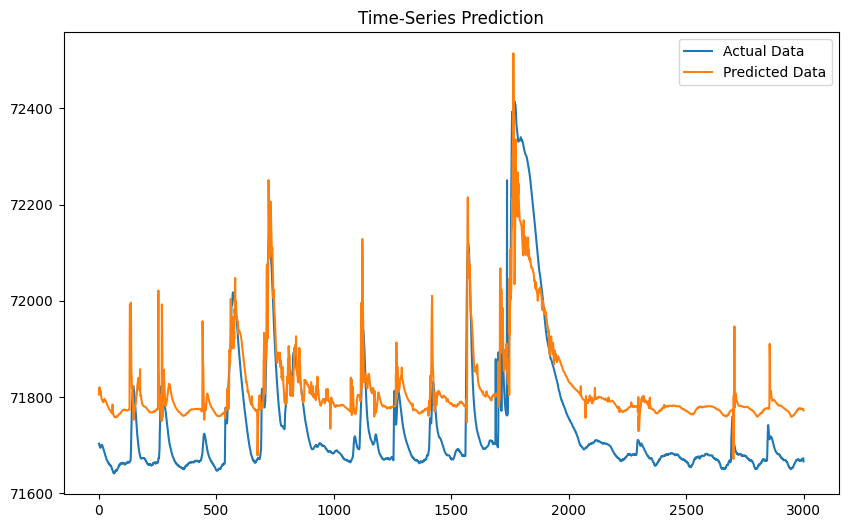

RMSE:  104.24539
NSE:  -0.039642453451552706


In [151]:
# Prediction and Plot with 20 hidden states
prediction_final = prediction.data.numpy()
y_test_tensors_final = y_test_tensors.data.numpy()
data_predict = mm.inverse_transform(prediction_final) # reverse transformation
dataY_plot = mm.inverse_transform(y_test_tensors_final)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting

plt.plot(true[4000:7000], label='Actual Data') # actual plot
plt.plot(preds[4000:7000], label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

mse = mean_squared_error(preds, true)
rmse = np.sqrt(mse)
nse = he.evaluator(he.nse, preds, true)
nse = nse[0]
print('RMSE: ',rmse)
print('NSE: ',nse)